# 시나리오

1. 상품등록 페이지 -> `AI 상품등록`
1. 휴대폰으로 찍은 사진 업로드
1. 배경 삭제
1. (옵션) 이미지 필터링 (밝게, 뚜렷하게, 노이즈 제거, 특정 영역 inpainting)
1. 상품 정보 추출
1. 배경 교체
1. 상품 임시 등록


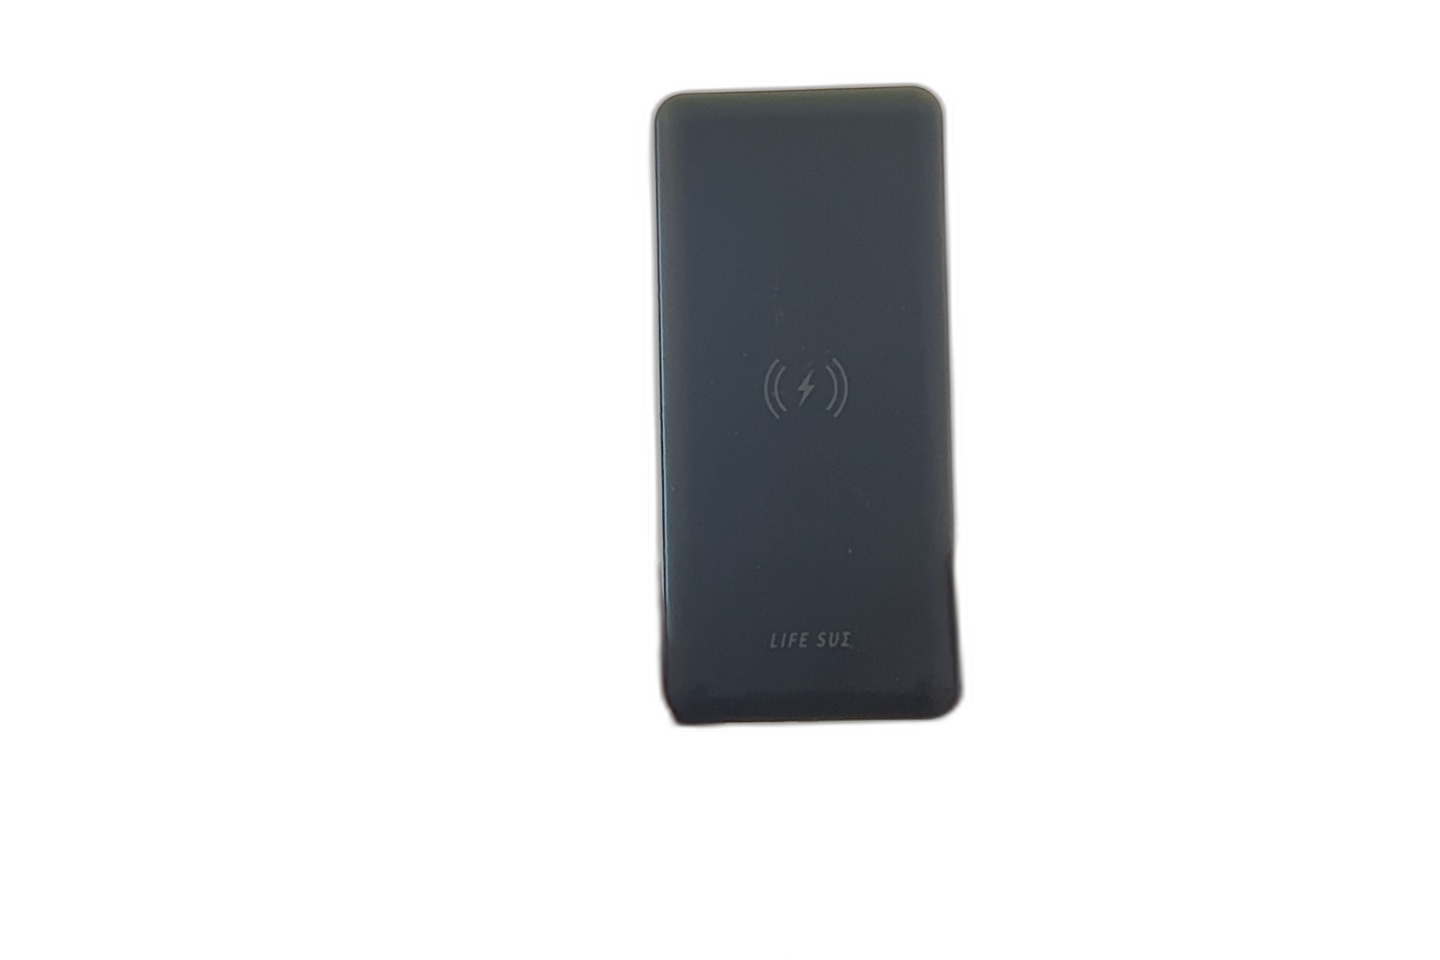

In [1]:
from poc.utils import display_image, remove_background
from IPython.display import Image, display
import rich

## 배경 제거
output = remove_background("aaa.jpg")

display_image(output, width=500)

In [3]:
import os

from langchain.schema import HumanMessage
from langchain_core.output_parsers import JsonOutputParser, PydanticOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel

from poc.utils import bytes_to_base64

GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY", "")

# 이미지와 텍스트를 함께 처리하는 모델
vision_model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash", google_api_key=GOOGLE_API_KEY
)


input_image = bytes_to_base64(output)


class ProductInfo(BaseModel):
    productName: str
    categoryName: str
    suggestionKeyword: str
    productDescription: str
    colors: list[str]
    price: int


pydantic_parser = PydanticOutputParser(pydantic_object=ProductInfo)

message = HumanMessage(
    content=[
        {
            "type": "text",
            "text": """
                온라인 쇼핑몰에 판매 할 상품 이미지야. 
                상품명, 카테고리, 특징적인 키워드, 상품설명, 가격, 색상(1개만, #는 빼줘) 추천해줘.
                아래와 같은 JSON형태로 부탁해.

                {
                    "productName": "상품명",
                    "categoryName": "카테고리",
                    "suggestionKeyword": "특징적인 키워드",
                    "productDescription": "상품설명",
                    "colors": ["#000000"],
                    "price": 10000,
                }
            """,
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{input_image}"},
        },
    ]
)


In [4]:
chain = vision_model | pydantic_parser

productResponse = chain.invoke([message])


In [ ]:
rich.print(productResponse)


ProductInfo(
    productName='LIFE SUI 무선 충전 보조배터리',
    categoryName='휴대폰 액세서리',
    suggestionKeyword='무선충전, 보조배터리, 휴대용, 고속충전',
    productDescription='LIFE SUI 무선 충전 보조배터리로 언제 어디서든 편리하게 스마트 기기를 충전하세요. 깔끔한 
디자인과 강력한 성능을 자랑합니다.',
    colors=['586167'],
    price=29900
)

In [7]:
from typing import List, Optional

from langchain.schema import HumanMessage
from pydantic import BaseModel

input_text = """
색상은 빨,주,노 사이즈는 10cm, 20cm, 30cm 무게는 1kg,2kg,5kg 로 생성해줘

모든 옵션가는 1000원이고 무게가 5kg일 경우만 50000으로 해줘.
10cm 재고는 100개고 나머지는 모두 50개로 해줘
"""


message = HumanMessage(
    content=[
        {
            "type": "text",
            "text": f"""
                쇼핑몰의 상품 옵션을 등록하려고 해.
                {input_text}

                옵션명이 N개 일경우 옵션명은 optionName1/optionName2... 식으로 나와야해.
                옵션의 총 갯수는 optionName * optionValue 수 만큼 얘기해줘야해.
                optionNo는 1부터 시작해.
                JSON형태로 출력해줘. 아래 포멧에 맞게 답변해줘
                
                {{"optionName":"", "optionValue":"", "price":0, "stock":10, "optionCode":"", "additionCode":" }}
                """,
        },
    ]
)


chain = vision_model | JsonOutputParser()

optionResponse = chain.invoke([message])


In [8]:
rich.print(optionResponse)

[
    {
        'optionNo': 1,
        'optionName': '색상/사이즈/무게',
        'optionValue': '빨/10cm/1kg',
        'price': 1000,
        'stock': 100,
        'optionCode': 'COLOR-RED-SIZE-10CM-WEIGHT-1KG',
        'additionCode': ''
    },
    {
        'optionNo': 2,
        'optionName': '색상/사이즈/무게',
        'optionValue': '빨/10cm/2kg',
        'price': 1000,
        'stock': 100,
        'optionCode': 'COLOR-RED-SIZE-10CM-WEIGHT-2KG',
        'additionCode': ''
    },
    {
        'optionNo': 3,
        'optionName': '색상/사이즈/무게',
        'optionValue': '빨/10cm/5kg',
        'price': 50000,
        'stock': 100,
        'optionCode': 'COLOR-RED-SIZE-10CM-WEIGHT-5KG',
        'additionCode': ''
    },
    {
        'optionNo': 4,
        'optionName': '색상/사이즈/무게',
        'optionValue': '빨/20cm/1kg',
        'price': 1000,
        'stock': 50,
        'optionCode': 'COLOR-RED-SIZE-20CM-WEIGHT-1KG',
        'additionCode': ''
    },
    {
        'optionNo': 5,
        'optionName': '색상/사이즈/무게',
        'optionValue': '빨/20cm/2kg',
        'price': 1000,
        'stock': 50,
        'optionCode': 'COLOR-RED-SIZE-20CM-WEIGHT-2KG',
        'additionCode': ''
    },
    {
        'optionNo': 6,
        'optionName': '색상/사이즈/무게',
        'optionValue': '빨/20cm/5kg',
        'price': 50000,
        'stock': 50,
        'optionCode': 'COLOR-RED-SIZE-20CM-WEIGHT-5KG',
        'additionCode': ''
    },
    {
        'optionNo': 7,
        'optionName': '색상/사이즈/무게',
        'optionValue': '빨/30cm/1kg',
        'price': 1000,
        'stock': 50,
        'optionCode': 'COLOR-RED-SIZE-30CM-WEIGHT-1KG',
        'additionCode': ''
    },
    {
        'optionNo': 8,
        'optionName': '색상/사이즈/무게',
        'optionValue': '빨/30cm/2kg',
        'price': 1000,
        'stock': 50,
        'optionCode': 'COLOR-RED-SIZE-30CM-WEIGHT-2KG',
        'additionCode': ''
    },
    {
        'optionNo': 9,
        'optionName': '색상/사이즈/무게',
        'optionValue': '빨/30cm/5kg',
        'price': 50000,
        'stock': 50,
        'optionCode': 'COLOR-RED-SIZE-30CM-WEIGHT-5KG',
        'additionCode': ''
    },
    {
        'optionNo': 10,
        'optionName': '색상/사이즈/무게',
        'optionValue': '주/10cm/1kg',
        'price': 1000,
        'stock': 100,
        'optionCode': 'COLOR-ORANGE-SIZE-10CM-WEIGHT-1KG',
        'additionCode': ''
    },
    {
        'optionNo': 11,
        'optionName': '색상/사이즈/무게',
        'optionValue': '주/10cm/2kg',
        'price': 1000,
        'stock': 100,
        'optionCode': 'COLOR-ORANGE-SIZE-10CM-WEIGHT-2KG',
        'additionCode': ''
    },
    {
        'optionNo': 12,
        'optionName': '색상/사이즈/무게',
        'optionValue': '주/10cm/5kg',
        'price': 50000,
        'stock': 100,
        'optionCode': 'COLOR-ORANGE-SIZE-10CM-WEIGHT-5KG',
        'additionCode': ''
    },
    {
        'optionNo': 13,
        'optionName': '색상/사이즈/무게',
        'optionValue': '주/20cm/1kg',
        'price': 1000,
        'stock': 50,
        'optionCode': 'COLOR-ORANGE-SIZE-20CM-WEIGHT-1KG',
        'additionCode': ''
    },
    {
        'optionNo': 14,
        'optionName': '색상/사이즈/무게',
        'optionValue': '주/20cm/2kg',
        'price': 1000,
        'stock': 50,
        'optionCode': 'COLOR-ORANGE-SIZE-20CM-WEIGHT-2KG',
        'additionCode': ''
    },
    {
        'optionNo': 15,
        'optionName': '색상/사이즈/무게',
        'optionValue': '주/20cm/5kg',
        'price': 50000,
        'stock': 50,
        'optionCode': 'COLOR-ORANGE-SIZE-20CM-WEIGHT-5KG',
        'additionCode': ''
    },
    {
        'optionNo': 16,
        'optionName': '색상/사이즈/무게',
        'optionValue': '주/30cm/1kg',
        'price': 1000,
        'stock': 50,
        'optionCode': 'COLOR-ORANGE-SIZE-30CM-WEIGHT-1KG',
        'additionCode': ''
    },
    {
        'optionNo': 17,
        'optionName': '색상/사이즈/무게',
        'optionValue': '주/30cm/2kg',
        'price': 1000,
        'stock': 50,
        'optionCode': 'COLOR-ORANGE-SIZE-30CM-WEIGHT-

In [10]:
optionNames = optionResponse[0]["optionName"].split("/")
print(optionNames)


# 옵션값을 /로 구분하여 최대 5개까지 처리하는 함수
def parse_option_values(option_value: str):
    values = option_value.split("/")
    # 최대 5개까지만 처리하고 나머지는 무시
    values = values[:5]
    # 5개 미만인 경우 빈 문자열로 채움
    while len(values) < 5:
        values.append("")
    return values


# 옵션 데이터 변환
option_data = []
for option in optionResponse:
    option_values = parse_option_values(option["optionValue"])
    option_data.append(
        {
            "optionNo": option["optionNo"],
            "optionValue1": option_values[0],
            "optionValue2": option_values[1] if len(option_values) > 1 else "",
            "optionValue3": option_values[2] if len(option_values) > 2 else "",
            "optionValue4": option_values[3] if len(option_values) > 3 else "",
            "optionValue5": option_values[4] if len(option_values) > 4 else "",
            "optionPrice": option["price"],
            "optionViewFlag": "Y",
            "optionCode": option["optionCode"],
            "stockCount": option["stock"],
        }
    )

rich.print(option_data)


['색상', '사이즈', '무게']


[
    {
        'optionNo': 1,
        'optionValue1': '빨',
        'optionValue2': '10cm',
        'optionValue3': '1kg',
        'optionValue4': '',
        'optionValue5': '',
        'optionPrice': 1000,
        'optionViewFlag': 'Y',
        'optionCode': 'COLOR-RED-SIZE-10CM-WEIGHT-1KG',
        'stockCount': 100
    },
    {
        'optionNo': 2,
        'optionValue1': '빨',
        'optionValue2': '10cm',
        'optionValue3': '2kg',
        'optionValue4': '',
        'optionValue5': '',
        'optionPrice': 1000,
        'optionViewFlag': 'Y',
        'optionCode': 'COLOR-RED-SIZE-10CM-WEIGHT-2KG',
        'stockCount': 100
    },
    {
        'optionNo': 3,
        'optionValue1': '빨',
        'optionValue2': '10cm',
        'optionValue3': '5kg',
        'optionValue4': '',
        'optionValue5': '',
        'optionPrice': 50000,
        'optionViewFlag': 'Y',
        'optionCode': 'COLOR-RED-SIZE-10CM-WEIGHT-5KG',
        'stockCount': 100
    },
    {
        'optionNo': 4,
        'optionValue1': '빨',
        'optionValue2': '20cm',
        'optionValue3': '1kg',
        'optionValue4': '',
        'optionValue5': '',
        'optionPrice': 1000,
        'optionViewFlag': 'Y',
        'optionCode': 'COLOR-RED-SIZE-20CM-WEIGHT-1KG',
        'stockCount': 50
    },
    {
        'optionNo': 5,
        'optionValue1': '빨',
        'optionValue2': '20cm',
        'optionValue3': '2kg',
        'optionValue4': '',
        'optionValue5': '',
        'optionPrice': 1000,
        'optionViewFlag': 'Y',
        'optionCode': 'COLOR-RED-SIZE-20CM-WEIGHT-2KG',
        'stockCount': 50
    },
    {
        'optionNo': 6,
        'optionValue1': '빨',
        'optionValue2': '20cm',
        'optionValue3': '5kg',
        'optionValue4': '',
        'optionValue5': '',
        'optionPrice': 50000,
        'optionViewFlag': 'Y',
        'optionCode': 'COLOR-RED-SIZE-20CM-WEIGHT-5KG',
        'stockCount': 50
    },
    {
        'optionNo': 7,
        'optionValue1': '빨',
        'optionValue2': '30cm',
        'optionValue3': '1kg',
        'optionValue4': '',
        'optionValue5': '',
        'optionPrice': 1000,
        'optionViewFlag': 'Y',
        'optionCode': 'COLOR-RED-SIZE-30CM-WEIGHT-1KG',
        'stockCount': 50
    },
    {
        'optionNo': 8,
        'optionValue1': '빨',
        'optionValue2': '30cm',
        'optionValue3': '2kg',
        'optionValue4': '',
        'optionValue5': '',
        'optionPrice': 1000,
        'optionViewFlag': 'Y',
        'optionCode': 'COLOR-RED-SIZE-30CM-WEIGHT-2KG',
        'stockCount': 50
    },
    {
        'optionNo': 9,
        'optionValue1': '빨',
        'optionValue2': '30cm',
        'optionValue3': '5kg',
        'optionValue4': '',
        'optionValue5': '',
        'optionPrice': 50000,
        'optionViewFlag': 'Y',
        'optionCode': 'COLOR-RED-SIZE-30CM-WEIGHT-5KG',
        'stockCount': 50
    },
    {
        'optionNo': 10,
        'optionValue1': '주',
        'optionValue2': '10cm',
        'optionValue3': '1kg',
        'optionValue4': '',
        'optionValue5': '',
        'optionPrice': 1000,
        'optionViewFlag': 'Y',
        'optionCode': 'COLOR-ORANGE-SIZE-10CM-WEIGHT-1KG',
        'stockCount': 100
    },
    {
        'optionNo': 11,
        'optionValue1': '주',
        'optionValue2': '10cm',
        'optionValue3': '2kg',
        'optionValue4': '',
        'optionValue5': '',
        'optionPrice': 1000,
        'optionViewFlag': 'Y',
        'optionCode': 'COLOR-ORANGE-SIZE-10CM-WEIGHT-2KG',
        'stockCount': 100
    },
    {
        'optionNo': 12,
        'optionValue1': '주',
        'optionValue2': '10cm',
        'optionValue3': '5kg',
        'optionValue4': '',
        'optionValue5': '',
        'optionPrice': 50000,
        'optionViewFlag': 'Y',
        'optionCode': 'COLOR-ORANGE-SIZE-10CM-WEIGHT-5KG',
        'stockCount': 100
    },
    {
        'optionNo': 13,
        'optionValue1': '주',
        'optionVa

In [11]:
import os

import requests

# Docs : https://server-docs.godomall.com/?activeName=%EC%83%81%ED%92%88#/Goods/save-goods-api
# 쇼핑몰 관리자 : https://gdadmin-alpha.godomall.com/base/login.php
# 계정 : superAdmin / q1w2e3r4t5#
authorization = os.environ.get("GODO_AUTHORIZATION", "")
system_key = os.environ.get("GODO_SYSTEM_KEY", "")


url = "https://alpha-server-api.godomall.com/goods"
headers = {
    "accept": "application/json",
    "Version": "1.0",
    "authorization": f"Bearer {authorization}",
    "content-type": "application/json",
    "systemkey": system_key,
}
payload = {
    "scmNo": 1,
    "goodsName": {
        "name": f"{productResponse.productName}",
        "goodsNameFlag": "DEFAULT",
        "mainName": f"{productResponse.productName}",
        "listName": f"{productResponse.productName}",
        "detailName": f"{productResponse.productDescription}",
        "partnerName": f"{productResponse.productName}",
        "purchaseName": f"{productResponse.productName}",
    },
    "deliverySno": 2,
    "categoryCode": "007",
    "displayFlag": "N",
    "displayMobileFlag": "N",
    "sellFlag": "N",
    "sellMobileFlag": "N",
    "state": "NEW",
    "taxStatus": "TAXABLE",
    "stockFlag": "Y",
    "soldOutFlag": "N",
    "restockFlag": "N",
    "goodsCode": "G00281",
    "searchWords": [f"{productResponse.suggestionKeyword}"],
    "openDate": "2025-02-10 14:01:02",
    "imageDetailViewFlag": "Y",
    "colors": productResponse.colors,
    "weight": 1.23,
    "brandCode": "007",
    "makerName": "제조사명",
    "originName": "원산지",
    "modelNo": "MODEL001",
    "memo": "상품 메모",
    "makeDate": "2025-02-10",
    "launchDate": "2025-02-10",
    "effectiveStartDate": "2025-02-01 00:00:00",
    "effectiveEndDate": "2028-02-20 00:00:00",
    "onlyAdultFlag": "N",
    "totalStock": 50,
    "salesUnit": 1,
    "salesStartDate": "2025-02-10 00:00:00",
    "salesEndDate": "2025-02-09 00:00:00",
    "cultureBenefitFlag": "N",
    "daumFlag": "N",
    "goodsPrice": {
        "price": productResponse.price,
        "priceString": "가격대체문구",
        "fixedPrice": 25000,
        "costPrice": 13000,
    },
    "goodsDescription": {
        "description": "PC 상품 상세설명",
        "mobileDescription": "모바일 상품 상세설명",
        "shortDescription": "상품 짧은설명",
        "eventDescription": "이벤트 문구, 마케팅 제휴서비스(네이버 쇼핑, 다음 쇼핑하우)에 사용됩니다",
    },
    "fixedOrderCount": {"type": "OPTION", "minOrderCount": 1, "maxOrderCount": 20},
    "guideInfo": {
        "deliveryInfoCode": "002001",
        "asInfoCode": "003001",
        "refundInfoCode": "004001",
        "exchangeInfoCode": "005001",
    },
    "goodsMustInfo": [
        [{"infoTitle": "용량(중량), 수량, 크기", "infoValue": "상품 상세참조"}],
        [
            {"infoTitle": "관련법상 표시사항", "infoValue": "상품 상세참조"},
            {"infoTitle": "소비자상담 관련 전화번호", "infoValue": "상품 상세참조"},
        ],
    ],
    "kcmarkInfoList": [
        {
            "type": "CHILDREN_SAFETY_CERTIFICATION",
            "certificationDate": "2024-02-27 00:00:00",
            "certificationNumber": "4922193128377772",
        },
        {
            "type": "CHILDREN_SAFETY_CONFIRMATION",
            "certificationDate": "2023-01-10 00:00:00",
            "certificationNumber": "1239871248912390",
        },
        {
            "type": "CHILDREN_SUPPLIER_CONFORMITY",
            "certificationDate": "2023-12-11 00:00:00",
            "certificationNumber": "2389472398478923",
        },
    ],
    "count": 0,
    "date": "2025-02-27 00:00:00",
    "externalVideo": {
        "url": "https://youtu.be/n8Er5CjTbO0",
        "width": 650,
        "height": 400,
    },
    "mileage": {"unit": "PERCENT", "value": 10},
    "discount": {"unit": "PRICE", "value": 2000},
    "payLimits": ["PG", "BANK_TRANSFER", "PAYCO"],
    "seoTag": {
        "title": "타이틀",
        "author": "메타태그 설명자",
        "description": "메타태그 설명",
        "keywords": ["메타태그키워드1", "메타태그키워드2", "메타태그키워드3"],
    },
    "goodsOption": {
        "displayFlag": "DIVIDED",
        "names": optionNames,
        "values": option_data,
    },
    "textOptions": [
        {
            "optionName": "추가요청사항",
            "mustFlag": "N",
            "addPrice": 1000,
            "inputLimit": 200,
        },
        {"optionName": "구매자정보", "mustFlag": "Y", "addPrice": 0, "inputLimit": 200},
    ],
    "goodsAddInfoList": [
        {"title": "추가정보1", "value": "추가정보 첫번째 항목의 값입니다"},
        {"title": "추가정보2", "value": "추가정보 두번째 항목의 값입니다"},
    ],
    "goodsIcons": [
        {
            "kind": "UNLIMITED",
            "code": "icon0001",
            "startDate": None,
            "endDate": None,
            "benefitSno": 0,
        },
        {
            "kind": "LIMITED",
            "code": "icon0002",
            "startDate": "2025-02-15 00:00:00",
            "endDate": "2025-02-25 00:00:00",
            "benefitSno": 0,
        },
        {
            "kind": "LIMITED",
            "code": "icon0003",
            "startDate": "2025-02-15 00:00:00",
            "endDate": "2025-02-25 00:00:00",
            "benefitSno": 0,
        },
    ],
    "goodsImage": {
        "imageStorage": "DEFAULT",
    },
    "naver": {
        "importFlag": "PARALLEL_IMPORT",
        "productFlag": "SCHEDULED",
        "ageGroup": "YOUNG",
        "gender": "COMMON",
        "tags": ["네이버검색태그1", "네이버검색태그2"],
        "attributes": ["네이버속성1", "네이버속성2"],
        "categoryId": "네이버쇼핑카테고리ID",
        "productId": "네이버가격비교페이지ID",
        "brandCertFlag": "N",
        "npayAble": "ALL",
        "npayAcumAble": "ALL",
    },
    "naverBook": {"goodsType": "PAPER", "isbn": "1234567890"},
}


response = requests.post(url, headers=headers, json=payload)
print(response.json())


{'results': [{'goodsNo': 1000001644, 'goodsName': 'LIFE SUI 무선 충전 보조배터리', 'goodsCode': 'G00281'}]}
